In [63]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from scenario import*
from scipy.optimize import curve_fit
from scipy.stats import t

import numpy as np

In [64]:
# Extracting of scenarios from indoor logs
coaxial_directory = r'data\coaxial\logs'
indoor_directory = r'data\indoor\logs'

scenarios_indoor = extract_scenarios_from_text_files(indoor_directory)
scenarios_coaxial = extract_scenarios_from_text_files(coaxial_directory)

scenarios_indoor_1M = []
scenarios_indoor_2M = []
for scenario in scenarios_indoor:
    if scenario.test_type == 'indoor':
        if scenario.bandwidth == '1M':
            scenarios_indoor_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_indoor_2M.append(scenario)

scenarios_coaxial_1M = []
scenarios_coaxial_2M = []
for scenario in scenarios_coaxial:
    if scenario.test_type == 'coaxial':
        if scenario.bandwidth == '1M' :
            scenarios_coaxial_1M.append(scenario)
        elif scenario.bandwidth == '2M':
            scenarios_coaxial_2M.append(scenario)

# To dataframe
df_all = scenarios_to_dataframe(scenarios_indoor + scenarios_coaxial)
df_1M = scenarios_to_dataframe(scenarios_coaxial_1M +scenarios_indoor_1M)
df_2M = scenarios_to_dataframe(scenarios_coaxial_2M +scenarios_indoor_2M)
df_indoor_1M = scenarios_to_dataframe(scenarios_indoor_1M)
df_indoor_2M = scenarios_to_dataframe(scenarios_indoor_2M)
df_coaxial_1M = scenarios_to_dataframe(scenarios_coaxial_1M)
df_coaxial_2M = scenarios_to_dataframe(scenarios_coaxial_2M)


atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
atrium_tests
BC_tests
BM_tests
CO_tests
vortex_tests
results_indoor_STA_1MHz
results_indoor_STA_2MHz
floor_1_pos_1_1Mhz_indoor_1827.txt
floor_1_pos_2_1Mhz_indoor_1829.txt
floor_1_pos_3_1Mhz_indoor_1830.txt
floor_2_pos_1_1Mhz_indoor_1833.txt
floor_2_pos_2_1Mhz_indoor_1834.txt
floor_2_pos_2_1Mhz_indoor_1836.txt
floor_2_pos_3_1Mhz_indoor_1837.txt
floor_2_pos_3_1Mhz_indoor_1839.txt
point_floor_1_1Mhz_indoor_1621.txt
point_floor_2_1Mhz_indoor_1624.txt
point_floor_2_1Mhz_indoor_1637.txt
point_floor_2_1Mhz_indoor_1638.txt
point_floor_2_1Mhz_indoor_1640.txt
point_floor_3_1Mhz_indoor_1629.txt
point_floor_3_1Mhz_indoor_1631.txt
point_floor_4_1Mhz_indoor_1644.txt
point_floor_4_mv_1Mhz_indoor_1645.txt
floor_1_1Mhz_indoor_1706.txt
floor_1_pos_2_1Mhz_indoor_1707.txt
floor_1_pos_2_1Mhz_indoor_1711.txt
floor_1_pos_3_1Mhz_indoor_1710.txt
floor_2_pos_1_1Mhz_indoor_1715.txt
floor_2_pos_2_1Mhz_indoor_1716.txt
floor_2_pos_2_1Mhz_indoor_1717.txt
floor_2_p

# Coaxial Setting

### Throughput vs RSSI: Sigmoid Function Model

The relationship between throughput (TP) and Received Signal Strength Indicator (RSSI) in wireless communication often exhibits an S-shaped or sigmoid curve. This behavior can be modeled using a logistic function.

#### Sigmoid Function Equation

The general form of the sigmoid function used to model the TP vs RSSI relationship is:

$ \text{TP}(rssi) = \frac{L}{1 + e^{-k (rssi - x_0)}} + b $

where:
- $\text{TP}(rssi)$ is the throughput at a given RSSI value.
- $L$ is the curve's maximum value (asymptote).
- $x_0$ is the RSSI value at the curve's midpoint.
- $k$ is the logistic growth rate or steepness of the curve.
- $b$ is the baseline throughput when RSSI is very low.

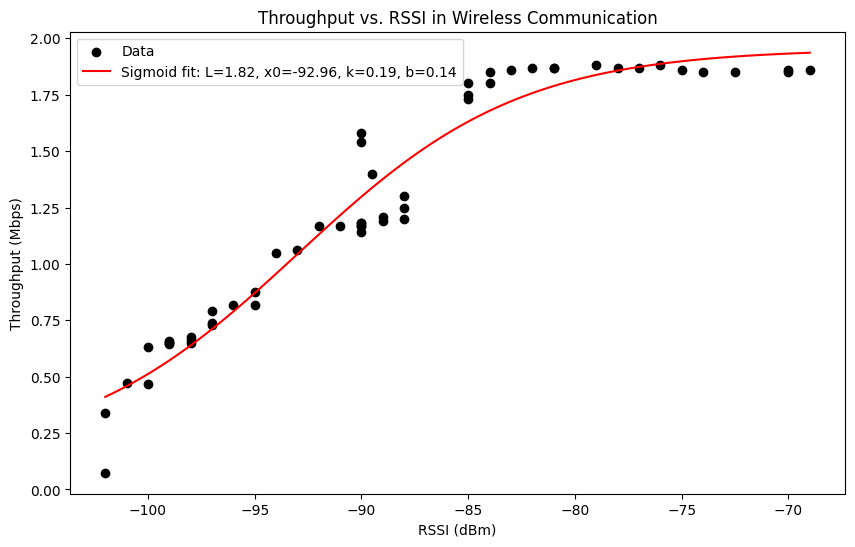

In [65]:
# Sample data (replace this with your actual data)
rssi_data = np.linspace(-100, 0, 50)  # RSSI values in dBm
throughput_data = 50 / (1 + np.exp(-0.1 * (rssi_data + 50)))  # Simulated throughput values

rssi_data=df_coaxial_1M['RSSI Median']
throughput_data=df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)']

# Define the sigmoid model
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Fit the sigmoid model to the data
popt, pcov = curve_fit(sigmoid, rssi_data, throughput_data, p0=[max(throughput_data), np.median(rssi_data), 1, min(throughput_data)])
perr = np.sqrt(np.diag(pcov))  # Calculate the standard deviation errors of the parameters

# Generate data for plotting the fitted curve
rssi_fit = np.linspace(min(rssi_data), max(rssi_data), 100)
throughput_fit = sigmoid(rssi_fit, *popt)

# Calculate the t-value for the confidence interval
alpha = 0.95  # 95% confidence interval
n = len(rssi_data)  # number of data points
p = len(popt)  # number of parameters
dof = max(0, n - p)  # degrees of freedom
tval = t.ppf((1 + alpha) / 2., dof)  # t-value for the confidence interval

# Calculate the confidence interval for the sigmoid function
def sigmoid_confidence_interval(x, popt, pcov, tval):
    # Get the Jacobian matrix at the fitted parameters
    J = np.array([sigmoid(x, *popt + np.eye(len(popt))[:,i]) - sigmoid(x, *popt) for i in range(len(popt))]).T
    # Compute the variance of the fit at each point
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    # Compute the standard error of the fit at each point
    se_y_fit = np.sqrt(var_y_fit)
    # Compute the confidence interval
    ci = tval * se_y_fit
    return ci

# Calculate the confidence interval
confidence_interval = sigmoid_confidence_interval(rssi_fit, popt, pcov, tval)

# Plot the data, fitted curve, and confidence interval
plt.figure(figsize=(10, 6))
plt.scatter(rssi_data, throughput_data, label='Data', color='black')
plt.plot(rssi_fit, throughput_fit, label=f'Sigmoid fit: L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, b={popt[3]:.2f}', color='red')
# plt.fill_between(rssi_fit, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color='red', alpha=0.2, label='Confidence interval')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs. RSSI in Wireless Communication')
plt.show()

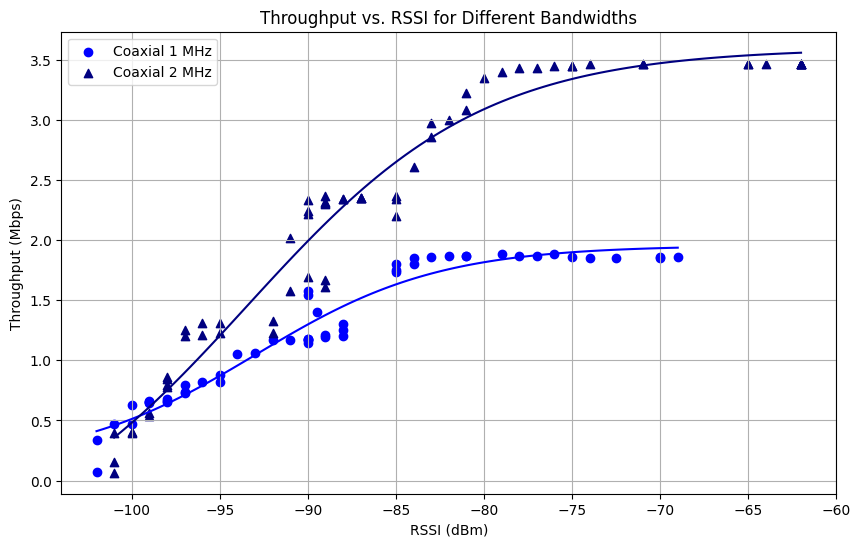

In [66]:
# Define the sigmoid model
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Function to calculate confidence interval for the sigmoid model
def calculate_sigmoid_confidence_interval(x, popt, pcov, tval):
    J = np.array([sigmoid(x, *popt + np.eye(len(popt))[:,i]) - sigmoid(x, *popt) for i in range(len(popt))]).T
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    se_y_fit = np.sqrt(var_y_fit)
    ci = tval * se_y_fit
    return ci

# Function to fit the sigmoid model and plot the results
def fit_and_plot_throughput_vs_rssi(df, label, color, marker='o'):
    rssi_data = df['RSSI Median']
    throughput_data = df['TX iPerf Bitrate (Mbits/sec)']
    
    popt, pcov = curve_fit(sigmoid, rssi_data, throughput_data, p0=[max(throughput_data), np.median(rssi_data), 1, min(throughput_data)])
    perr = np.sqrt(np.diag(pcov))
    
    rssi_fit = np.linspace(min(rssi_data), max(rssi_data), 100)
    throughput_fit = sigmoid(rssi_fit, *popt)
    
    alpha = 0.95
    n = len(rssi_data)
    p = len(popt)
    dof = max(0, n - p)
    tval = t.ppf((1 + alpha) / 2., dof)
    
    confidence_interval = calculate_sigmoid_confidence_interval(rssi_fit, popt, pcov, tval)

    plt.scatter(rssi_data, throughput_data, label=label, color=color, marker=marker)
    plt.plot(rssi_fit, throughput_fit,  color=color) # label=f'Fit {label}: L={popt[0]:.2f}, x0={popt[1]:.2f}, k={popt[2]:.2f}, b={popt[3]:.2f}')
    # plt.fill_between(rssi_fit, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color=color, alpha=0.2, label=f'Confidence interval {label}')

# Plotting the two curves
plt.figure(figsize=(10, 6))

fit_and_plot_throughput_vs_rssi(df_coaxial_1M, 'Coaxial 1 MHz', 'blue', 'o')
fit_and_plot_throughput_vs_rssi(df_coaxial_2M, 'Coaxial 2 MHz', 'navy', '^')
# fit_and_plot_throughput_vs_rssi(df_indoor_1M, 'Indoor 1 MHz', 'red', 'o')
# fit_and_plot_throughput_vs_rssi(df_indoor_2M, 'Indoor 2 MHz', 'darkorange', '^')

plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid()
plt.title('Throughput vs. RSSI for Different Bandwidths')
plt.show()

c:\Users\raffoul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\raffoul\AppData\Local\Temp\ipykernel_12888\1201791361.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_model, rssi_shifted, throughput_data+eps)
C:\Users\raffoul\AppData\Local\Temp\ipykernel_12888\1201791361.py:3: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b
C:\Users\raffoul\AppData\Local\Temp\ipykernel_12888\1201791361.py:7: RuntimeWarning: invalid value encountered in subtract
  J = np.array([log_model(x, *popt + np.eye(len(popt))[:,i]) - log_model(x, *popt) for i in range(len(popt))]).T
C:\Users\raffoul\AppData\Local\Temp\ipykernel_12888\1201791361.py:8: RuntimeWarning: invalid value encountered in matmul
  var_y_fit = np.sum((J @ pcov) * J, axis=1)


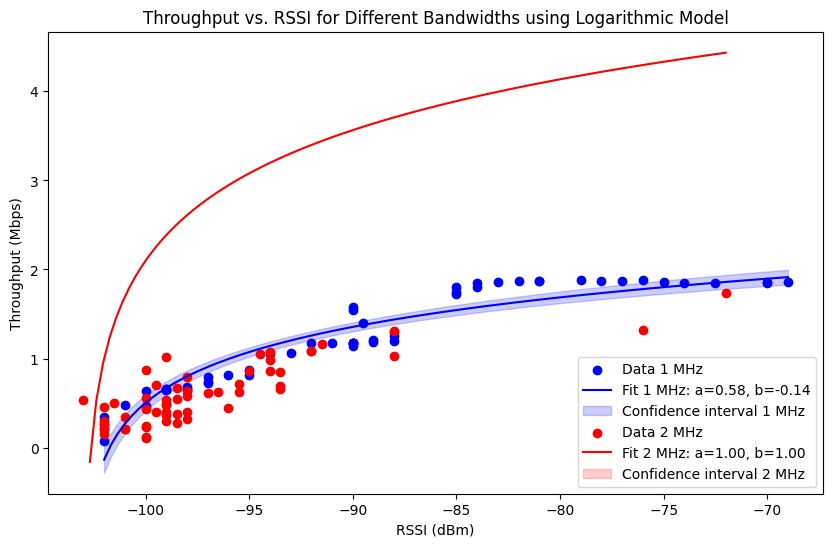

In [67]:
# Define the logarithmic model
def log_model(x, a, b):
    return a * np.log(x) + b

# Function to calculate confidence interval for the logarithmic model
def calculate_log_confidence_interval(x, popt, pcov, tval):
    J = np.array([log_model(x, *popt + np.eye(len(popt))[:,i]) - log_model(x, *popt) for i in range(len(popt))]).T
    var_y_fit = np.sum((J @ pcov) * J, axis=1)
    se_y_fit = np.sqrt(var_y_fit)
    ci = tval * se_y_fit
    return ci

# Function to fit the log model and plot the results
def fit_and_plot_throughput_vs_rssi_log(df, label, color, marker, min_rssi):
    rssi_data = df['RSSI Median']
    throughput_data = df['TX iPerf Bitrate (Mbits/sec)']
    
    # Shift RSSI data to avoid log(0)
    rssi_shifted = rssi_data - min_rssi + 1
    eps=1e-6
    popt, pcov = curve_fit(log_model, rssi_shifted, throughput_data+eps)
    perr = np.sqrt(np.diag(pcov))
    
    rssi_fit = np.linspace(min(rssi_shifted), max(rssi_shifted), 100)
    throughput_fit = log_model(rssi_fit, *popt)
    
    alpha = 0.95
    n = len(rssi_data)
    p = len(popt)
    dof = max(0, n - p)
    tval = t.ppf((1 + alpha) / 2., dof)
    
    confidence_interval = calculate_log_confidence_interval(rssi_fit, popt, pcov, tval)
    
    plt.scatter(rssi_data, throughput_data, label=f'Data {label}', color=color, marker=marker)
    plt.plot(rssi_fit + min_rssi - 1, throughput_fit, label=f'Fit {label}: a={popt[0]:.2f}, b={popt[1]:.2f}', color=color)
    plt.fill_between(rssi_fit + min_rssi - 1, throughput_fit - confidence_interval, throughput_fit + confidence_interval, color=color, alpha=0.2, label=f'Confidence interval {label}')

# Plotting the two curves
plt.figure(figsize=(10, 6))

min_rssi = min(df_coaxial_1M['RSSI Median'].min(), df_coaxial_2M['RSSI Median'].min())
fit_and_plot_throughput_vs_rssi_log(df_coaxial_1M, '1 MHz', 'blue', 'o', min_rssi)
fit_and_plot_throughput_vs_rssi_log(df_indoor_1M, '2 MHz', 'red', 'o', min_rssi)

plt.xlabel('RSSI (dBm)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs. RSSI for Different Bandwidths using Logarithmic Model')
plt.show()

Model: Sigmoid, R-squared: 0.9473, AIC: -221.45, BIC: -213.49
Model: Logarithmic, R-squared: 0.9111, AIC: -197.24, BIC: -193.27
Model: Sigmoid, R-squared: 0.9625, AIC: -190.59, BIC: -182.01
Model: Logarithmic, R-squared: 0.9380, AIC: -162.93, BIC: -158.64


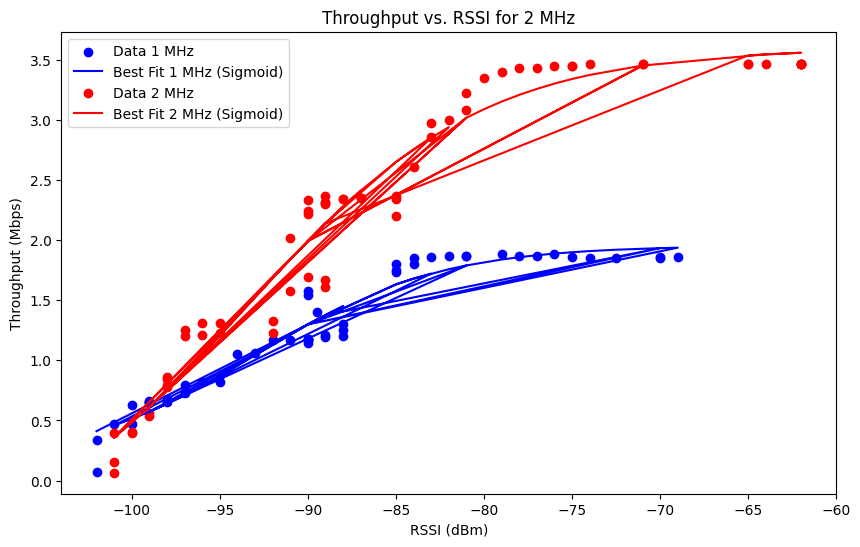

In [68]:
# Define models
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

def log_model(x, a, b):
    return a * np.log(x) + b

# Function to compute R-squared
def compute_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Function to compute AIC
def compute_aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

# Function to compute BIC
def compute_bic(n, rss, k):
    return n * np.log(rss / n) + k * np.log(n)

# Function to fit and evaluate models
def fit_and_evaluate_model(x, y, model_func, initial_params, model_name):
    try:
        popt, pcov = curve_fit(model_func, x, y, p0=initial_params)
        y_pred = model_func(x, *popt)
        rss = np.sum((y - y_pred) ** 2)
        n = len(y)
        k = len(popt)
        
        r_squared = compute_r_squared(y, y_pred)
        aic = compute_aic(n, rss, k)
        bic = compute_bic(n, rss, k)
        
        return {
            'model': model_name,
            'params': popt,
            'r_squared': r_squared,
            'aic': aic,
            'bic': bic,
            'y_pred': y_pred
        }
    except Exception as e:
        print(f"Failed to fit {model_name} model: {e}")
        return None

# Shift RSSI values to avoid log(0) and ensure positive values
shift_value = 104  # Shift to make RSSI values positive

# Evaluate models for df_coaxial_1M
results_1M = []
results_1M.append(fit_and_evaluate_model(df_coaxial_1M['RSSI Median'], df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], sigmoid, [max(df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)']), np.median(df_coaxial_1M['RSSI Median']), 1, min(df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'])], 'Sigmoid'))
results_1M.append(fit_and_evaluate_model(df_coaxial_1M['RSSI Median'] + shift_value, df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], log_model, [1, 1], 'Logarithmic'))

# Evaluate models for df_coaxial_2M
results_2M = []
results_2M.append(fit_and_evaluate_model(df_coaxial_2M['RSSI Median'], df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], sigmoid, [max(df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)']), np.median(df_coaxial_2M['RSSI Median']), 1, min(df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'])], 'Sigmoid'))
results_2M.append(fit_and_evaluate_model(df_coaxial_2M['RSSI Median'] + shift_value, df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], log_model, [1, 1], 'Logarithmic'))

# Print results for 1M
for result in results_1M:
    if result:
        print(f"Model: {result['model']}, R-squared: {result['r_squared']:.4f}, AIC: {result['aic']:.2f}, BIC: {result['bic']:.2f}")

# Print results for 2M
for result in results_2M:
    if result:
        print(f"Model: {result['model']}, R-squared: {result['r_squared']:.4f}, AIC: {result['aic']:.2f}, BIC: {result['bic']:.2f}")

# Plot the best model for each dataset
def plot_best_model(results, x, y, label, color, shift_value):
    best_model = min(results, key=lambda result: result['aic'])
    plt.scatter(x, y, label=f'Data {label}', color=color, marker='o')
    if best_model['model'] == 'Logarithmic':
        plt.plot(x, best_model['y_pred'], label=f'Best Fit {label} ({best_model["model"]})', color=color)
    else:
        plt.plot(x, best_model['y_pred'], label=f'Best Fit {label} ({best_model["model"]})', color=color)
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()
    plt.title(f'Throughput vs. RSSI for {label}')

plt.figure(figsize=(10, 6))
plot_best_model(results_1M, df_coaxial_1M['RSSI Median'], df_coaxial_1M['TX iPerf Bitrate (Mbits/sec)'], '1 MHz', 'blue', shift_value)
plot_best_model(results_2M, df_coaxial_2M['RSSI Median'], df_coaxial_2M['TX iPerf Bitrate (Mbits/sec)'], '2 MHz', 'red', shift_value)
plt.show()

# MCS vs RSSI Sensitivity Curve with Test Data Points

## Description

This graph represents the relationship between Modulation and Coding Scheme (MCS) and Received Signal Strength Indicator (RSSI). The step function demonstrates the sensitivity curve where MCS values stay constant until a specific RSSI threshold is reached, after which the MCS value steps up. The plot also includes test data points with different markers to distinguish between various data sets.

## Key Points

1. **Sensitivity Curve**:
   - The sensitivity curve is plotted as a step function, indicating the RSSI thresholds for each MCS value.
   - MCS values range from 10 to 7.
   - RSSI values are shown in dBm, increasing from left to right.

2. **Data Points**:
   - Test data points are plotted using circles and triangles to represent different types of data.
   - Red circles and blue triangles indicate the MCS values at specific RSSI measurements from the test data.

## Interpretation

- **MCS Levels**:
  - MCS levels remain constant until the RSSI value reaches the next threshold, indicating the minimum RSSI required for each MCS level.
  - For example, MCS -1 (representing 10) is valid until the RSSI reaches -98 dBm, after which MCS 0 becomes valid up to -95 dBm.

- **Test Data Points**:
  - The test data points help validate the sensitivity curve by showing actual measurements of MCS at various RSSI levels.
  - Differences in markers help distinguish between different sets of test data, providing a visual comparison.

## Technical Details

- **MCS vs RSSI Sensitivity Curve**:
  - MCS values: [-1, 0, 1, 2, 3, 4, 5, 6, 7]
  - RSSI thresholds: [-98, -95, -92, -90, -87, -83, -79, -78, -77]

- **Plotting Markers**:
  - Circles (`o`) represent 1Mhz measurments, Triangles (`^`) represent 2 MHz.
  - Red is used for coaxial setting and Blue for indoor.

The graph provides a comprehensive view of how MCS values change with varying RSSI, along with actual test measurements to validate the sensitivity curve.


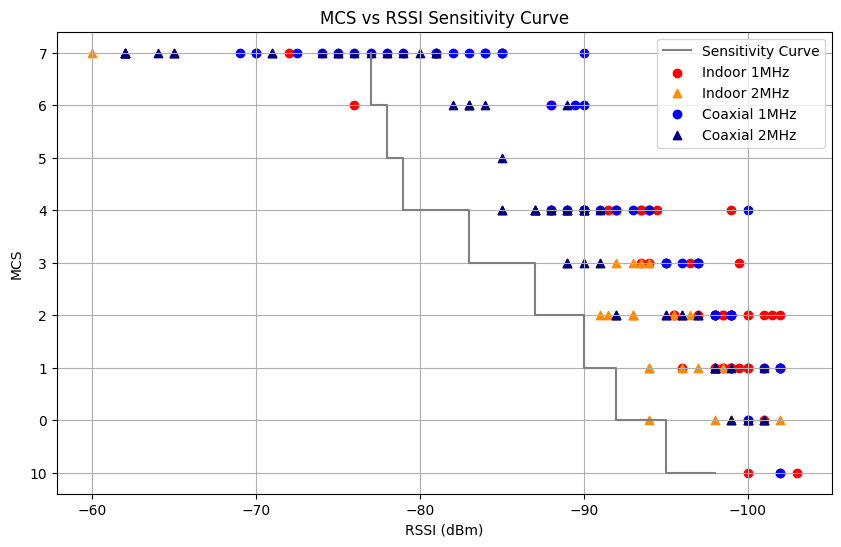

In [97]:
# Adjust the MCS and sensitivity values to reflect MCS 10 below 0
mcs_values = [-1, 0, 1, 2, 3, 4, 5, 6, 7]
sensitivity_values = [-98, -95, -92, -90, -87, -83, -79, -78, -77]

# Adjust for step plot with MCS 10 below 0


rssi_data = df_all['RSSI Median']
mcs_data = df_all['MCS']

offset = 0 # add 5 curves seems to fit

sensitivity_steps = [-98+offset]  # Start with a value below the first sensitivity
mcs_steps = [-1]  # Start with MCS 10

for i in range(len(mcs_values)):
    sensitivity_steps.append(sensitivity_values[i]+offset)
    mcs_steps.append(mcs_values[i])
    if i != len(mcs_values) - 1:
        sensitivity_steps.append(sensitivity_values[i+1]+offset)
        mcs_steps.append(mcs_values[i])

# Create the step plot
plt.figure(figsize=(10, 6))
plt.step(sensitivity_steps, mcs_steps, where='post', label='Sensitivity Curve', color='grey')

# Plot the test data points
mcs_indoor_1M = df_indoor_1M['MCS']

plt.scatter(df_indoor_1M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_1M['MCS']], color='red', marker='o', label='Indoor 1MHz')
plt.scatter(df_indoor_2M['RSSI Median'], [-1 if x == 10 else x for x in df_indoor_2M['MCS']], color='darkorange', marker='^', label='Indoor 2MHz')
plt.scatter(df_coaxial_1M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_1M['MCS']], color='blue', marker='o', label='Coaxial 1MHz')
plt.scatter(df_coaxial_2M['RSSI Median'], [-1 if x == 10 else x for x in df_coaxial_2M['MCS']], color='navy', marker='^', label='Coaxial 2MHz')


plt.xlabel('RSSI (dBm)')
plt.ylabel('MCS')
plt.title('MCS vs RSSI Sensitivity Curve')
plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'])

plt.gca().invert_xaxis()  # Invert y-axis to have MCS in descending order
plt.grid(True)
plt.legend()
plt.show()

# Throughput vs MCS


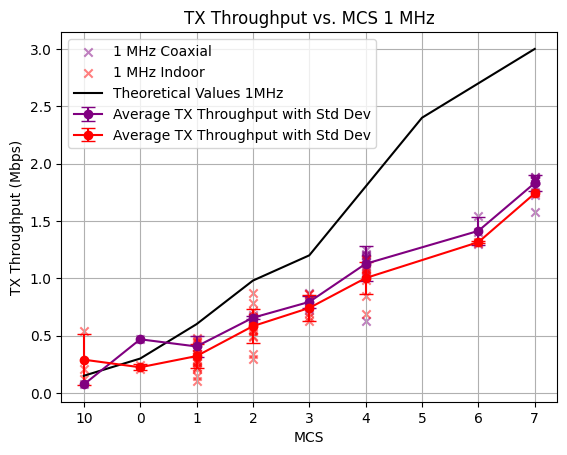

In [89]:
def plot_tx_vs_mcs_theoretical(color1, color2):
    

    mcs_val = list(range(-1, 8))
    
    th_values_1M= [0.15, 0.3, 0.6, 0.98, 1.2, 1.8, 2.4, 2.7, 3.0]
    plt.plot(mcs_val, th_values_1M, color=color1, label='Theoretical Values 1MHz')
    mcs_val_2M = list(range(0, 8))
    # th_values_2M = [0.65,1.3,1.95,2.6,3.9,5.2,5.85,6.5]
    # plt.plot(mcs_val_2M, th_values_2M, color=color2, label='Theretical Values 2MHz')


def plot_tx_throughput_vs_mcs(df_measurements, label, color):
    # Replace MCS 10 with -1
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Group by MCS and calculate the statistics
    grouped = df_measurements.groupby('MCS')['TX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    std_throughput = grouped.std()
    q1_throughput = grouped.quantile(0.25)
    q3_throughput = grouped.quantile(0.75)

    # Prepare data for plotting
    mcs = mean_throughput.index
    mean_values = mean_throughput.values
    std_values = std_throughput.values
    q1_values = q1_throughput.values
    q3_values = q3_throughput.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(mcs, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average TX Throughput with Std Dev', color=color)
    plt.scatter(df_measurements['MCS'],df_measurements['TX iPerf Bitrate (Mbits/sec)'], marker='x', label=label, color=color, alpha=0.5)
    # Plot the shaded area for the interquartile range
    # plt.fill_between(mcs, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean TX Throughput': mean_throughput,
        'Std Dev TX Throughput': std_throughput,
        '1st Quartile TX Throughput': q1_throughput,
        '3rd Quartile TX Throughput': q3_throughput
    })
    # print(statistics_df)


plot_tx_throughput_vs_mcs(df_coaxial_1M, '1 MHz Coaxial', 'purple')
plot_tx_throughput_vs_mcs(df_indoor_1M, '1 MHz Indoor', 'red')
# plot_tx_throughput_vs_mcs(df_2M, '2 MHz', 'green')
plot_tx_vs_mcs_theoretical('black', 'grey')
# Labels and title-
plt.xlabel('MCS')
plt.ylabel('TX Throughput (Mbps)')
plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'])

plt.title('TX Throughput vs. MCS 1 MHz')
plt.grid(True)
plt.legend()
plt.show()


# Indoor Setting

plotting rssi vs number of walls,
getting average at each walls then having points together

In [103]:
# Extracting of scenarios of specific buildings from indoor logs
indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\atrium_tests'
scenario_atrium_1M = extract_scenarios_from_text_files(indoor_directory)
df_atrium_1M = scenarios_to_dataframe(scenario_atrium_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\CO_tests'
scenario_CO_1M= extract_scenarios_from_text_files(indoor_directory)
df_CO_1M = scenarios_to_dataframe(scenario_CO_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\BM_tests'
scenario_BM_1M= extract_scenarios_from_text_files(indoor_directory)
df_BM_1M = scenarios_to_dataframe(scenario_BM_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\vortex_tests'
scenario_vortex_1M= extract_scenarios_from_text_files(indoor_directory) 
df_vortex_1M = scenarios_to_dataframe(scenario_vortex_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_1MHz\BC_tests'
scenario_BC_1M= extract_scenarios_from_text_files(indoor_directory)
df_BC_1M = scenarios_to_dataframe(scenario_BC_1M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\atrium_tests'
scenarios_atrium_2M = extract_scenarios_from_text_files(indoor_directory)
df_atrium_2M = scenarios_to_dataframe(scenarios_atrium_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\CO_tests'
scenario_CO_2M= extract_scenarios_from_text_files(indoor_directory)
df_CO_2M = scenarios_to_dataframe(scenario_CO_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\BM_tests'
scenario_BM_2M= extract_scenarios_from_text_files(indoor_directory)
df_BM_2M = scenarios_to_dataframe(scenario_BM_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\vortex_tests'
scenario_vortex_2M= extract_scenarios_from_text_files(indoor_directory) 
df_vortex_2M = scenarios_to_dataframe(scenario_vortex_2M)

indoor_directory = r'data\indoor\logs\results_indoor_STA_2MHz\BC_tests'
scenario_BC_2M= extract_scenarios_from_text_files(indoor_directory)
df_BC_2M = scenarios_to_dataframe(scenario_BC_2M)

df_all_wo_vortex = scenarios_to_dataframe(scenario_CO_1M+ scenario_BM_1M + scenario_BC_1M +scenario_atrium_1M)

floor_1_pos_1_1Mhz_indoor_1827.txt
floor_1_pos_2_1Mhz_indoor_1829.txt
floor_1_pos_3_1Mhz_indoor_1830.txt
floor_2_pos_1_1Mhz_indoor_1833.txt
floor_2_pos_2_1Mhz_indoor_1834.txt
floor_2_pos_2_1Mhz_indoor_1836.txt
floor_2_pos_3_1Mhz_indoor_1837.txt
floor_2_pos_3_1Mhz_indoor_1839.txt
point_A_1Mhz_indoor_1544.txt
point_B_1Mhz_indoor_1547.txt
point_C_1Mhz_indoor_1550.txt
point_C_1Mhz_indoor_1552.txt
point_D_1Mhz_indoor_1554.txt
point_D_1Mhz_indoor_1557.txt
point_E_1Mhz_indoor_1600.txt
point_E_1Mhz_indoor_1605.txt
point_E_fixed_10_1Mhz_indoor_1615.txt
floor_1_1Mhz_indoor_1706.txt
floor_1_pos_2_1Mhz_indoor_1707.txt
floor_1_pos_2_1Mhz_indoor_1711.txt
floor_1_pos_3_1Mhz_indoor_1710.txt
floor_2_pos_1_1Mhz_indoor_1715.txt
floor_2_pos_2_1Mhz_indoor_1716.txt
floor_2_pos_2_1Mhz_indoor_1717.txt
floor_2_pos_3_1Mhz_indoor_1719.txt
floor_2_pos_4_1Mhz_indoor_1720.txt
floor_1_pos_1_1Mhz_indoor_1725.txt
floor_1_pos_2_1Mhz_indoor_1726.txt
floor_2_pos_2_1Mhz_indoor_1730.txt
floor_2_pos_3_1Mhz_indoor_1732.txt
f

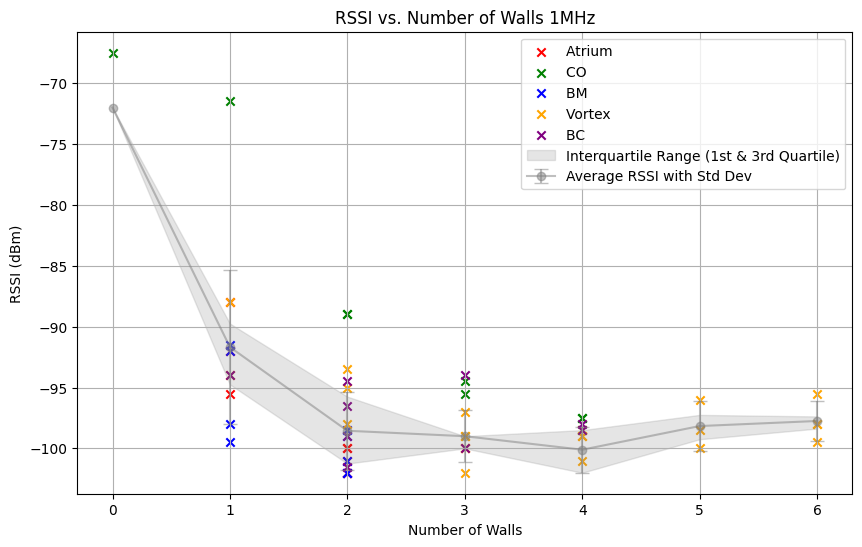

In [ ]:
def plot_rssi_vs_walls(df_measurements):
    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['RSSI Median']
    mean_rssi = grouped.mean()
    std_rssi = grouped.std()
    q1_rssi = grouped.quantile(0.25)
    q3_rssi = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_rssi.index
    mean_values = mean_rssi.values
    std_values = std_rssi.values
    q1_values = q1_rssi.values
    q3_values = q3_rssi.values

    

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average RSSI with Std Dev', color='grey', alpha=0.5)

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')


    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean RSSI': mean_rssi,
        'Std Dev RSSI': std_rssi,
        '1st Quartile RSSI': q1_rssi,
        '3rd Quartile RSSI': q3_rssi
    })
    # print(statistics_df)

def plot_scatter_rssi_vs_walls(df_measurements, label, color ='blue'):
    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['RSSI Median']
    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values ,color=color, label=label, marker='x')

# Plotting the graph
plt.figure(figsize=(10, 6))
df_CO_1M['RSSI Median'] += 0.5
plot_scatter_rssi_vs_walls(df_atrium_1M, 'Atrium ', 'red')
plot_scatter_rssi_vs_walls(df_CO_1M, 'CO ', 'green')
plot_scatter_rssi_vs_walls(df_BM_1M, 'BM ', 'blue')
plot_scatter_rssi_vs_walls(df_vortex_1M, 'Vortex ', 'orange')
plot_scatter_rssi_vs_walls(df_BC_1M, 'BC ', 'purple')

plot_rssi_vs_walls(df_indoor_1M)
# Labels and title
plt.xlabel('Number of Walls')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs. Number of Walls 1MHz')
plt.grid(True)
plt.legend()
plt.show()


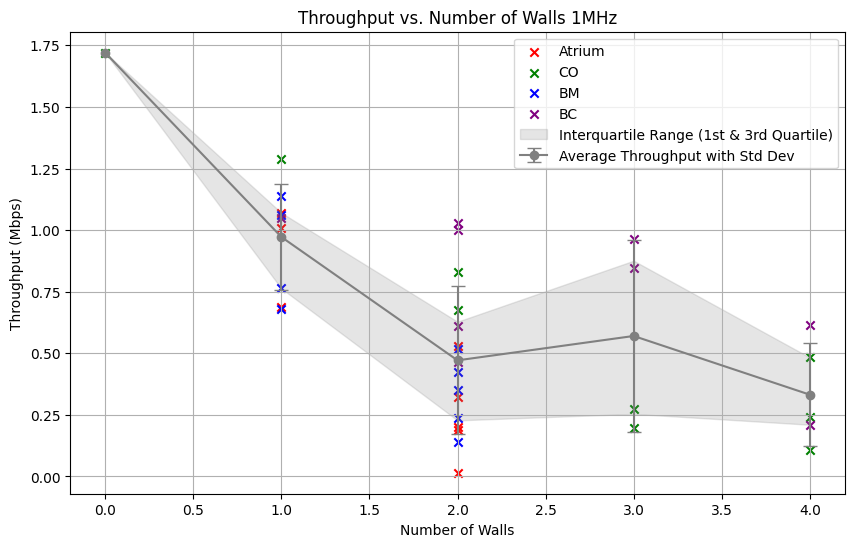

In [107]:
def plot_throughput_vs_walls(df_measurements, color):
    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['RX iPerf Bitrate (Mbits/sec)']
    mean_throughput = grouped.mean()
    std_throughput = grouped.std()
    q1_throughput = grouped.quantile(0.25)
    q3_throughput = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_throughput.index
    mean_values = mean_throughput.values
    std_values = std_throughput.values
    q1_values = q1_throughput.values
    q3_values = q3_throughput.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average Throughput with Std Dev', color=color)

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean Throughput': mean_throughput,
        'Std Dev Throughput': std_throughput,
        '1st Quartile Throughput': q1_throughput,
        '3rd Quartile Throughput': q3_throughput
    })
    # print(statistics_df)

def plot_scatter_throughput_vs_walls(df_measurements, label, color ='blue'):
    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['RX iPerf Bitrate (Mbits/sec)'] 

    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values, color=color, label=label, marker='x')

# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_throughput_vs_walls(df_atrium_1M, 'Atrium', 'red')
plot_scatter_throughput_vs_walls(df_CO_1M, 'CO', 'green')
plot_scatter_throughput_vs_walls(df_BM_1M, 'BM', 'blue')
# plot_scatter_throughput_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_throughput_vs_walls(df_BC_1M, 'BC', 'purple')

plot_throughput_vs_walls(df_atrium_1M)

# Labels and title
plt.xlabel('Number of Walls')
plt.ylabel('Throughput (Mbps)')
plt.title('Throughput vs. Number of Walls 1MHz')
plt.grid(True)
plt.legend()
plt.show()

       Mean MCS  Std Dev MCS  1st Quartile MCS  3rd Quartile MCS
Walls                                                           
3.0        17.0          NaN              17.0              17.0
5.0        15.0          NaN              15.0              15.0
6.0        14.0          NaN              14.0              14.0
7.0        14.0          NaN              14.0              14.0
9.0         4.0          NaN               4.0               4.0
10.0        8.0          NaN               8.0               8.0
11.0        5.0          NaN               5.0               5.0
12.0        6.0          NaN               6.0               6.0


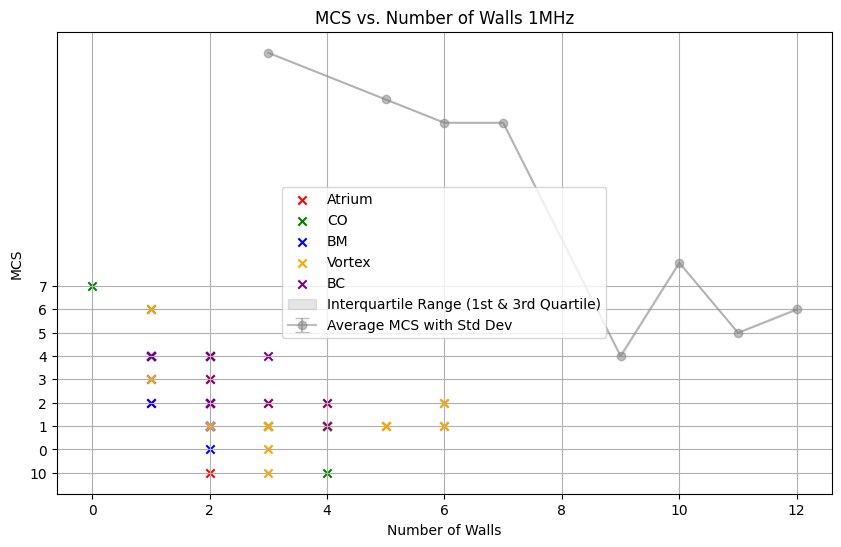

In [100]:
def plot_mcs_vs_walls(df_measurements):
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Group by number of walls and calculate the statistics
    grouped = df_measurements.groupby('Walls')['MCS']
    mean_mcs = grouped.mean()
    std_mcs = grouped.std()
    q1_mcs = grouped.quantile(0.25)
    q3_mcs = grouped.quantile(0.75)

    # Prepare data for plotting
    walls = mean_mcs.index
    mean_values = mean_mcs.values
    std_values = std_mcs.values
    q1_values = q1_mcs.values
    q3_values = q3_mcs.values

    # Plot the mean values with error bars for the standard deviation
    plt.errorbar(walls, mean_values, yerr=std_values, fmt='-o', capsize=5, label='Average MCS with Std Dev', color='grey', alpha=0.5)

    # Plot the shaded area for the interquartile range
    plt.fill_between(walls, q1_values, q3_values, color='gray', alpha=0.2, label='Interquartile Range (1st & 3rd Quartile)')

    # Display statistics for verification
    statistics_df = pd.DataFrame({
        'Mean MCS': mean_mcs,
        'Std Dev MCS': std_mcs,
        '1st Quartile MCS': q1_mcs,
        '3rd Quartile MCS': q3_mcs
    })
    print(statistics_df)

def plot_scatter_mcs_vs_walls(df_measurements, label, color='blue'):
    df_measurements['MCS'] = df_measurements['MCS'].replace(10, -1)

    # Prepare data for plotting
    walls = df_measurements['Walls']
    mean_values = df_measurements['MCS']

    # Plot the mean values with error bars for the standard deviation
    plt.scatter(walls, mean_values, color=color, label=label, marker='x')


# Plotting the graph
plt.figure(figsize=(10, 6))
plot_scatter_mcs_vs_walls(df_atrium_1M, 'Atrium', 'red')
plot_scatter_mcs_vs_walls(df_CO_1M, 'CO', 'green')
plot_scatter_mcs_vs_walls(df_BM_1M, 'BM', 'blue')
plot_scatter_mcs_vs_walls(df_vortex_1M, 'Vortex', 'orange')
plot_scatter_mcs_vs_walls(df_BC_1M, 'BC', 'purple')

all = df_atrium_1M + df_CO_1M + df_BM_1M + df_BC_1M
plot_mcs_vs_walls(all)

# Labels and title
plt.xlabel('Number of Walls')
plt.ylabel('MCS')
plt.title('MCS vs. Number of Walls 1MHz')
plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7], ['10', '0', '1', '2', '3', '4', '5', '6', '7'])

plt.grid(True)
plt.legend()
plt.show()